Osnabrück University - Computer Vision (Winter Term 2021/22) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before **14:00 of Tuesday, December 7, 2021**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

YOUR ANSWER HERE

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

YOUR ANSWER HERE

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

YOUR ANSWER HERE

## Assignment 1: Edge-based segmentation  [5 Points]

### a) Gradients
What is the gradient of a pixel? How do we calculate the first, how the second derivative of an image?  

The gradient of a pixel describes the directional change of color(intensity) from this pixel to neighboring ones. So, if - for example - we have an image with a white edge on dark background, the gradient of the pixels at that edge would be big, as there is a large change at that edge, and it would be oriented perpendicular to the edge because that is the direction of change.
The first derivative of the image is computed from the image and can be acquired by using filters like sobel or prewitt, as well as through other (approximation) methods. The second derivative is calculated in the same manner but instead of computing it from the image, the first derivative is used.
MonArch — heute um 10:21 Uhr

### b) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

In edge linking all pixels start as unprocessed. It is searched for the next unprocessed pixel and for that pixel, other pixels are searched in the edge of the given pixel that have similar gradient direction and magnitude. If there are other pixels found, those pixels are marked as edges and the same process will be repeated. It there are no pixels in the edge with similar gradient, another unprocessed pixel is searched and the algorithm is repeated. This goes on until there are no unprocessed pixels.Edge linking aims to yield edges that can be used for segmentation, so ideally closed edges. Putting all into consideration, it works by calculating edge pixels by thresholding the gradient magnitude and then tries to fill the gaps in the edges by merging edge points which are close enough and have a similar gradient direction and magnitude. As the last two conditions may not always be true for edges in an image (e.g. corners), edge linking might not result in closed edge contours.

### c) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

Generally, zero crossings are the points where a function crosses an axis and the sign changes. In this context zero crossings are the zero crossings in the second derivative of an image, which correspond to contours of connected segments (hills or valleys in the original function). Edges might be interrupted, which is not helpful, since our goal is to obtain a reasonable segmentation. Additionally, we need one step where we close these contours, or a method which provides closed edge contours. The detection of zero crossings can be used for this purpose. It is really important to smooth before the detection of zero crossing due to the fact that we will obtain too many segments, if we do not smooth beforehand. 

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

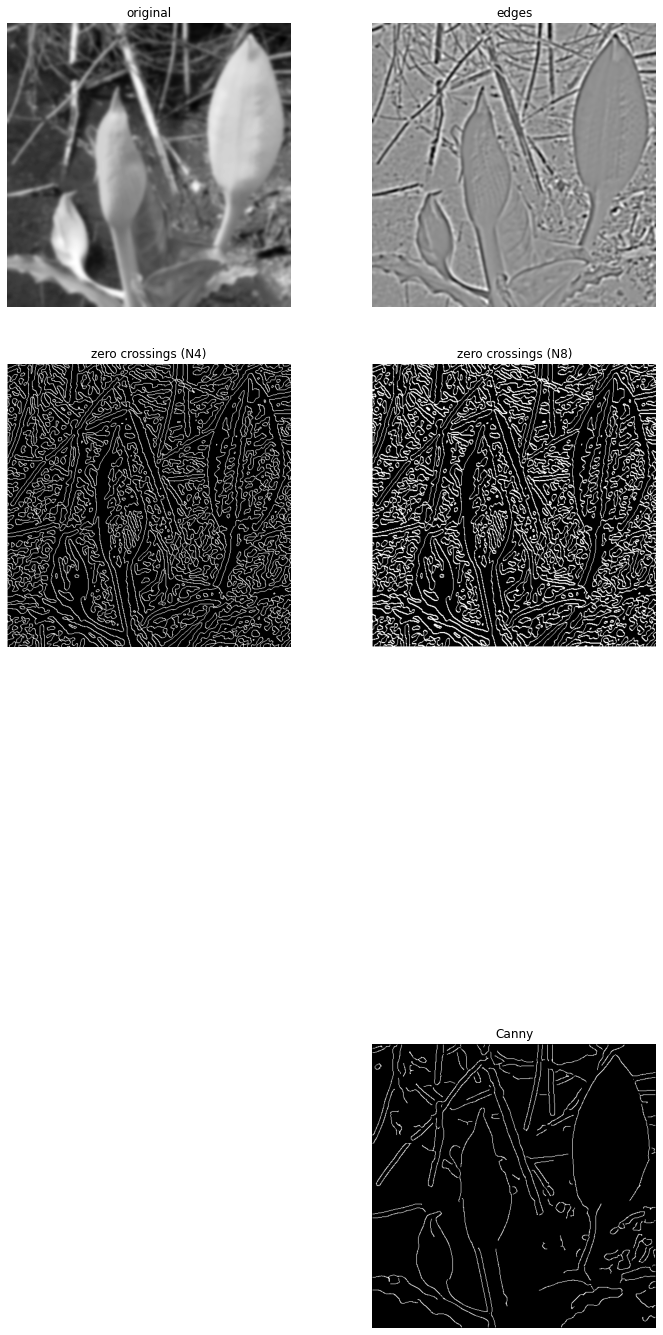

In [21]:
from skimage import filters
from skimage.feature import canny                
from skimage import filters
from skimage.feature import canny
from skimage.color import rgb2gray
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy

img = imread('images/swampflower.png').astype(float)
#img = imread('images/peppers.png').astype(float)

if len(img.shape)>2:
    img = rgb2gray(img)
img /= img.max()

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
img = scipy.ndimage.gaussian_filter(img, 3)

edges = scipy.ndimage.laplace(img)

# shifted copies of edge image so that we can simply multiply them in batch to avoid loops.
shifted_x = np.zeros(edges.shape)
shifted_y = shifted_x.copy()
shifted_xy1 = shifted_x.copy()
shifted_xy2 = shifted_x.copy()

# shift edges one pixel to the right (rightmost column cut off) and the non-cut block 
# assign to shifted_x. 
# Naturally, the first column will not get any pixels
shifted_x[:, 1:] = edges[:,:-1]

# shift edges one pixel down (bottom row cut off) and assign the non-cut block
# to shifted_y.
# Naturally, the first row will not get any pixels
shifted_y[1:, :] = edges[:-1,:]

# shift edges one to the right + one pixel up (rightmost column + top row cut off)
# and assign to shifted_xy1.
# Naturally, the first column + last row will not get any pixels
shifted_xy1[:-1, 1:] = edges[1:,:-1]

# shift edges one to the right + one pixel down (rightmost column + bottom row cut off)
# and assign the non-cut block to shifted_xy2.
# Naturally, the first column + first row will not get any pixels
shifted_xy2[1:, 1:] = edges[1:,:-1]

zero_crossings_n4 = np.zeros(edges.shape)
zero_crossings_n4[(edges * shifted_x <= 0) | (edges * shifted_y <= 0)] = 1
zero_crossings_n8 = np.zeros(edges.shape)
zero_crossings_n8[(edges * shifted_x <= 0) | (edges * shifted_y <= 0)
                 | (edges * shifted_xy1 <= 0)| (edges * shifted_xy2 <= 0)] = 1


plt.figure(figsize=(12, 24))
plt.gray()

plt.subplot(4,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(4,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(4,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(4,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )
#plt.subplot(4,2,5); plt.axis('off'); plt.imshow(grad_mag); plt.title('Gradient Magnitude' )
#plt.subplot(4,2,6); plt.hist(grad_mag.flatten(), 255, (0, grad_mag.max())); plt.title('Histogram Gradient Magnitude' )
#plt.subplot(4,2,7); plt.axis('off'); plt.imshow(zero_crossings_n8_thresh); plt.title('zero crossings (N8) Thresh' )
plt.subplot(4,2,8); plt.axis('off'); plt.imshow(canny(img,sigma=2)); plt.title('Canny')
plt.show()                

## Assignment 2: Watershed transform  [5 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



A watershed is a transformation which is defined on a grayscale image. The idea behind the watershed transform hinges on imagining a landscape with the gradient magnitudes of an image as the height at those points. Water collects in basins in this landscape, with watersheds being the boundaries between adjacent catchment basins. There are two approaches for filling the basins and finding the watersheds. The first one can be thought of as rain that falls evenly over the landscape, where the water then flows downhill, collecting in local minima until two pools of water meet and a watershed is defined. The second method can be imagined as a flood or rising ground water where the water level rises, filling valleys, and a watershed is detected when waters of different valleys meet.
The watershed transform always gives a closed contour as it finds the highest gradients surrounding lower gradients.The disadvantages of Watershed transform are that the encircling edges differ in strength and oversegmentation.

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildin functions for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

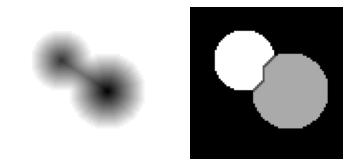

In [7]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline


def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img (ndarray): The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        edges (ndarray): A binary image containing the watersheds.
    """
    NO_LABEL = 0
    WATERSHED = 1
    new_label = 2
    
    
    # INITIALIZATION
    
    # initialize labels (first of all there are no labels assigned)
    label = np.zeros(img.shape, np.uint16)

    h = 0
    neighbors = [[0,1],[0,-1],[1,0],[-1,0], [1,1],[1,-1],[-1,1],[-1,-1]]
    #neighbors = [[0,1],[0,-1],[1,0],[-1,0]]
    while h <= np.max(img):# and (label.size - np.count_nonzero(label))!=0:
        
        # 3. get all just flooded locations
        f = np.where(img < h)
        
        for x,y in zip(f[0], f[1]):
            if(label[x,y]==NO_LABEL):
                
                # if YES: flooded now check 3 cases 
                
                # check neighbors
                prev_l = None
                n_labels = []
                ns=0
                nf=0
                
                # there are no neigbouring flooded pictures x,y is isolated
                for n in neighbors:
                    try:
                        if x+n[0] >= 0 and y+n[1]>=0:
                            l = label[x+n[0], y+n[1]]
                            n_labels.append(l)
                            ns+=1
                            if img[x+n[0], y+n[1]] >= h:
                                nf+=1

                    except IndexError:
                        pass
                 
                # label = new label 
                n_labels = np.array(n_labels)
                
                # if all neighbors are not flooded, start a new segment
                if nf == ns:
                    label[x,y] = new_label
                    new_label+=1
                    
                # if there are labled neighbors
                elif n_labels[n_labels>1].shape[0] > 0 :    
                    
                    # if they are identical, assign their label to this pixel
                    if np.unique(n_labels[n_labels>1]).shape[0] == 1:
                        label[x,y] = np.unique(n_labels[n_labels>1])[0]
                        
                    # otherwise there are differently labeled neighbors, so this must be a watershed
                    else:     
                        label[x,y] = WATERSHED
                        
                        
        

        h += 1
        
        # if NO: goto 3 
        
    return label




# # Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
img = np.logical_or(mask_circle1, mask_circle2)

import scipy.ndimage.morphology as morph
from skimage.util import invert
img =  invert(morph.distance_transform_edt(img))
img = img + np.abs(np.min(img))
img /= np.max(img)
img *= 255

#img = imageio.imread('images/dist_circles.png', pilmode='L')



w = watershed(img)

plt.gray()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(w)
plt.show()

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.
You can use build-in functions instead of your own watershed function.

C:\Users\lisag\AppData\Local\Temp/ipykernel_35960/446983622.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbour_indices = np.zeros(img.shape, dtype=np.bool)
C:\Users\lisag\AppData\Local\Temp/ipykernel_35960/446983622.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = np.zeros(A.shape, dtype=np.bool)


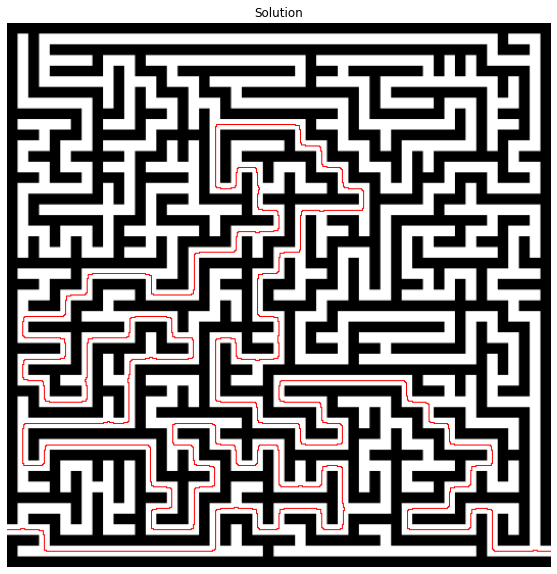

In [16]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
%matplotlib inline

img = imread('images/maze1.png', pilmode = 'L') # 'maze1.png' or 'maze2.png'

result = img[:,:,np.newaxis].repeat(3, 2)
result[watershed(distance_transform_edt(img)),1:3] = 0

plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(result)
plt.show()

In such an ideal maze (with one path and no loops) the path that leads through the maze divides the image in two parts. The watershed floods the image until two basins of water meet and as the path divides the image into to basins, the path is found as a watershed.

## Assignment 3: $k$-means segmentation [5 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

K-means clustering is an unsupervised machine learning algorithm. It divides the dataset into clusters by randomly placing centroids, assigning all points to the centroid closest to them, recomputing the centroids as mean of all points assigned to them, so that clusters are represented by their K centres of gravity. Going ahead, it minimizes the error measure until the local minimum is found by repeating the last two steps until the centroids move less than a specified threshold. In segmentation k means can be used for segmenting images using colors.

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.cdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector. (Empirically) determine a good value for $k$ for clustering the image 'peppers.png'.
**Bonus** If you want you can visualize the intermediate steps of the clustering process.

First lets take a look at how our image looks in RGB colorspace. 

<IPython.core.display.Javascript object>


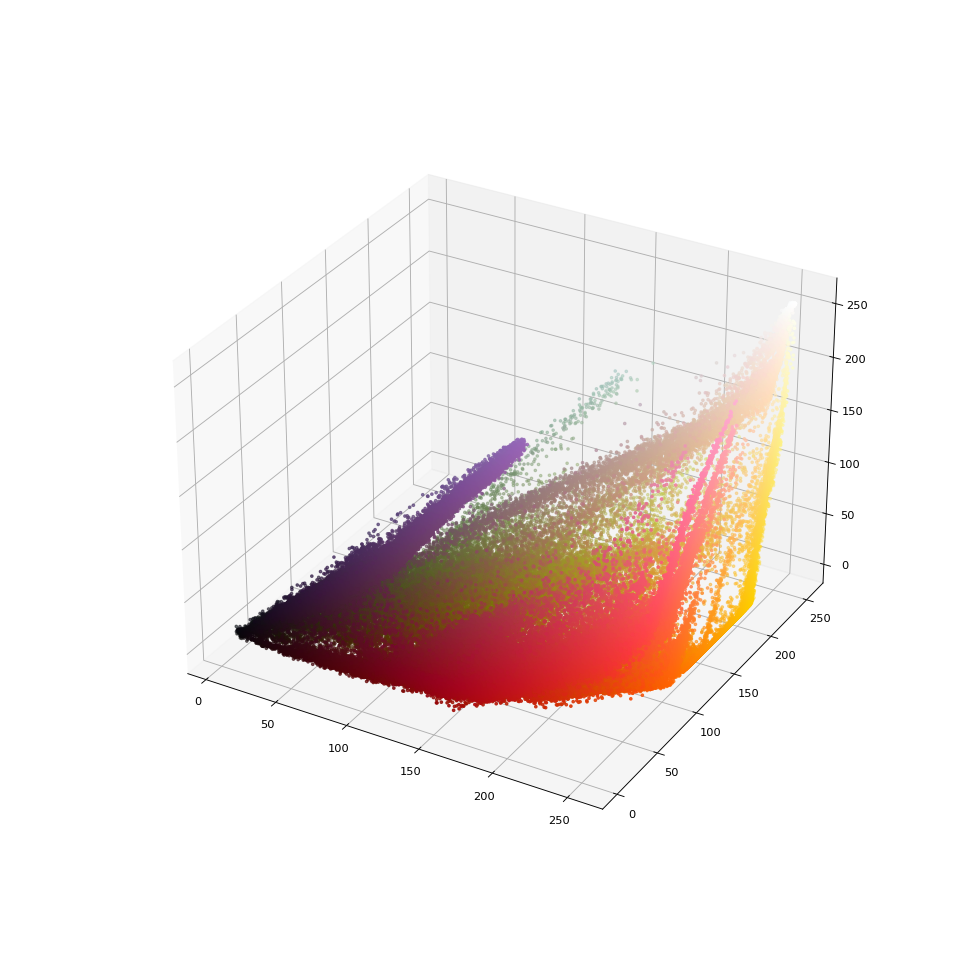

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib notebook

img = imread('images/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

3


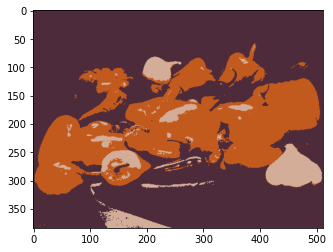

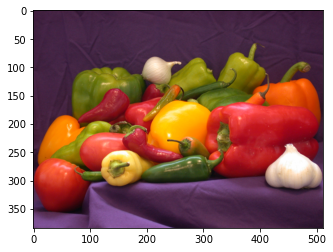

4


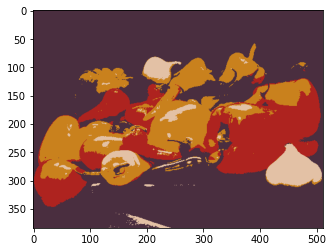

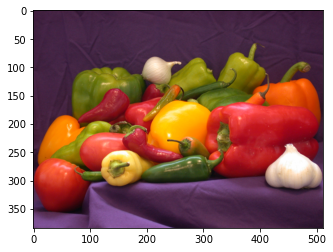

5


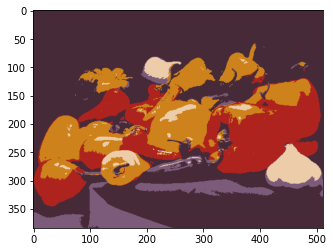

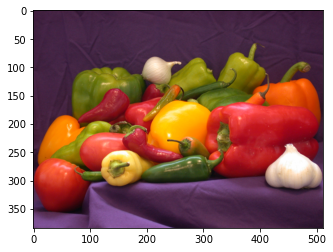

6


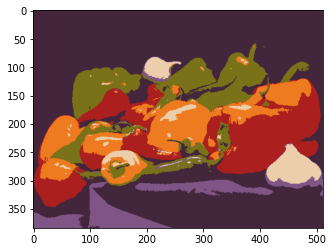

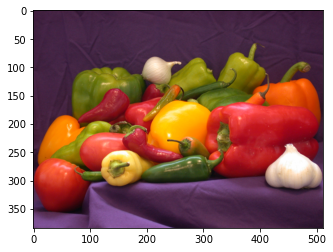

7


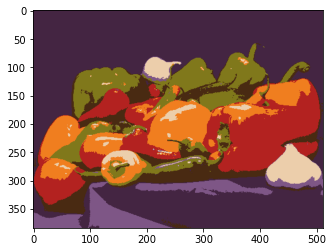

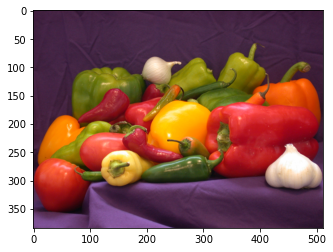

8


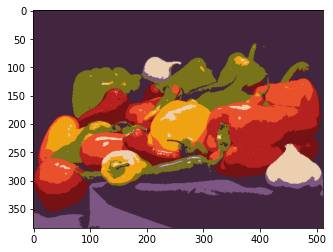

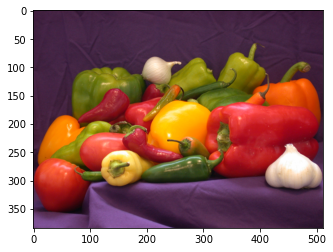

9


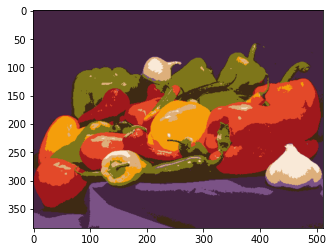

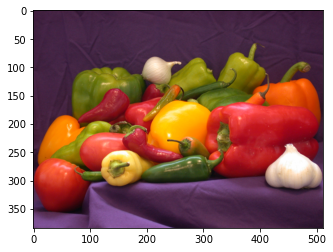

10


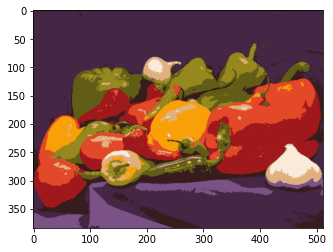

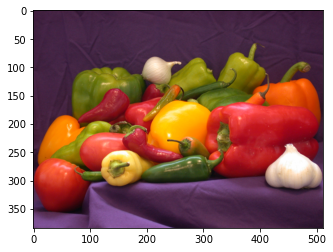

11


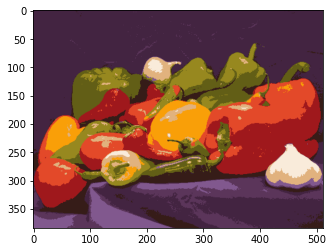

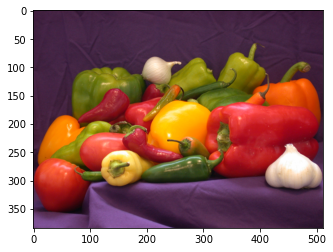

12


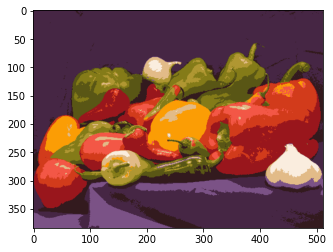

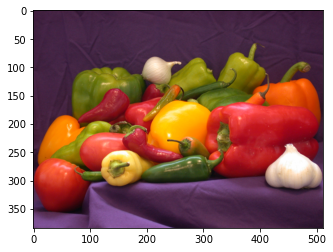

13


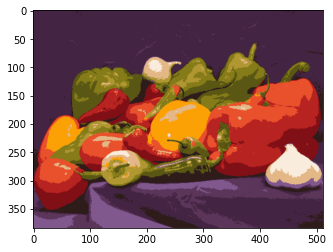

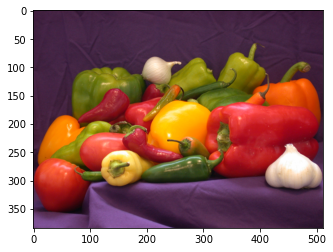

14


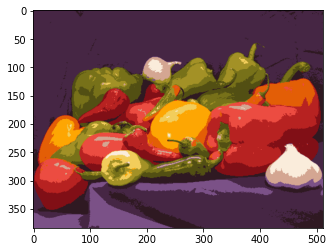

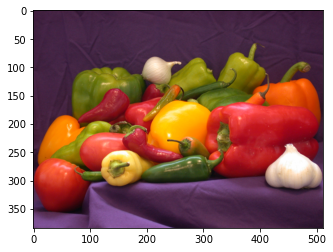

In [3]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from IPython import display
from imageio import imread
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline


def kmeans_rgb(img, k, threshold=0, do_display=None):
    """
    k-means clustering in RGB space.

    Args:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): 'number of clusters' x 3 array. 
            RGB color for each cluster center.
    """
    # YOUR CODE HERE

    # create suitable bounding box
    r_min = np.min(img[:,:,0])
    r_max = np.max(img[:,:,0])
    g_min = np.min(img[:,:,1])
    g_max = np.max(img[:,:,1])
    b_min = np.min(img[:,:,2])
    b_max = np.max(img[:,:,2])
    
    # initialize k random cluster centers within bounding box
    centroids = np.array([[random.uniform(r_min,r_max), random.uniform(g_min,g_max), random.uniform(b_min,b_max)] for i in range(k)])
    
    epsilon = threshold
    labels=()
    
    dist_moved=[float('inf')]
    
    # stop if the reference points have not moved more than epsilon
    while(max(dist_moved) > epsilon):
        # assign all data points to the best matching reference point
        
        # flatten image to calculate distances
        img_f = img.transpose(2,0,1).reshape(3,-1).transpose()        
        distances = cdist(img_f, centroids, 'euclidean')

        labels = np.argmin(distances, axis = 1).reshape(img.shape[0:2])

        dist_moved = []
        # update the reference points to the mean of the cluster - save the distances moved
        for i, point in enumerate(centroids):
            cluster = img[labels==i,:]
            
            # if a cluster has 0 elements, pick a new random position for the centroid
            # and add infinity to dist moved to prevent stopping after this step
            if cluster.size == 0:
                centroids[i] = np.array([random.uniform(r_min,r_max), random.uniform(g_min,g_max), random.uniform(b_min,b_max)])
                dist_moved.append(float('inf'))
            else:
                tmp = np.copy(point)
                point = np.mean(cluster, axis = 0)

                centroids[i] = np.array(point)

                dist_moved.append(distance.euclidean(point,tmp.tolist()))
        
        if do_display:
            
            for i, c in enumerate(centroids):
                colored[labels==i,:]=c
                
            plt.imshow(colored)
            fig.canvas.draw()
            plt.show()


    return labels, centroids


img = imread('images/peppers.png')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img)



for k in range(3,15):
    print(k)
    cluster, centers = kmeans_rgb(img, k=k, threshold=0, do_display=False)
    colored = img.copy()
    for i, c in enumerate(centers):
        colored[cluster==i,:]=c
    plt.imshow(colored)
    plt.show()
    plt.imshow(img)
    plt.show()

**c)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

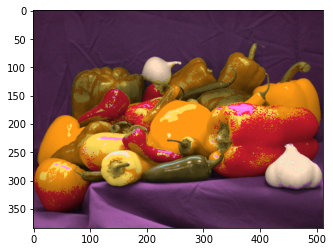

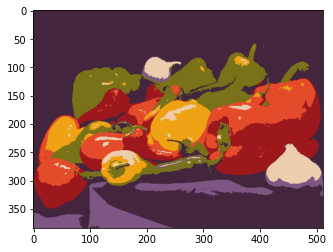

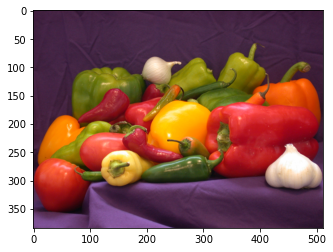

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import color
from imageio import imread
%matplotlib inline
import random

#from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

img = imread('images/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold = 0, ignore_channel='v'):
    """
    k-means clustering in HSV space.

    Args:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    # YOUR CODE HERE
    # create suitable bounding box
    if ignore_channel == 'h':
        h_min = np.min(img[:,:,1])
        h_max = np.max(img[:,:,1])
        s_min = np.min(img[:,:,2])
        s_max = np.max(img[:,:,2])
    
    elif ignore_channel == 's':
        h_min = np.min(img[:,:,0])
        h_max = np.max(img[:,:,0])
        s_min = np.min(img[:,:,2])
        s_max = np.max(img[:,:,2])

        
    elif ignore_channel == 'v':   
        h_min = np.min(img[:,:,0])
        h_max = np.max(img[:,:,0])
        s_min = np.min(img[:,:,1])
        s_max = np.max(img[:,:,1])

    # initialize k random cluster centers within bounding box
    centroids = np.array([[random.uniform(h_min,h_max), random.uniform(s_min,s_max)] for i in range(k)])
    
    epsilon = threshold
    labels=()
    
    dist_moved=[float('inf')]
    
    # stop if the reference points have not moved more than epsilon
    while(max(dist_moved) > epsilon):
        # assign all data points to the best matching reference point
        
        # flatten image to calculate distances
        img_f = img[:,:,:2].transpose(2,0,1).reshape(2,-1).transpose()  
        
        distances = cdist(img_f, centroids, 'euclidean')

        labels = np.argmin(distances, axis = 1).reshape(img.shape[0:2])

        dist_moved = []
        # update the reference points to the mean of the cluster - save the distances moved
        for i, point in enumerate(centroids):
            if ignore_channel == 'h':
                cluster = img[labels==i,1:]
            elif ignore_channel == 's':
                cluster = img[labels==i,::2]
            elif ignore_channel == 'v':  
                cluster = img[labels==i,:2]
            
            
            # if a cluster has 0 elements, pick a new random position for the centroid
            # and add infinity to dist moved to prevent stopping after this step
            if cluster.size == 0:
                centroids[i] = np.array([random.uniform(h_min,h_max), random.uniform(s_min,s_max)])
                dist_moved.append(float('inf'))
            else:
                tmp = np.copy(point)
                point = np.mean(cluster, axis = 0)
                centroids[i] = np.array(point)

                dist_moved.append(distance.euclidean(point,tmp.tolist()))

    
    colored = img.copy()
    for i, c in enumerate(centroids):
        if ignore_channel == 'h':
            colored[labels==i,1:]=c
        elif ignore_channel == 's':
            colored[labels==i,::2]=c
        elif ignore_channel == 'v':  
            colored[labels==i,:2]=c
        

    return labels, centroids, colored


img_hsv = color.rgb2hsv(img)
k = 7
theta = 0.01

cluster, centers_hsv, colored = kmeans_hsv(img_hsv[:,:,:], k, theta, 'v')
plt.imshow(color.hsv2rgb(colored))
plt.show()

# cluster, centers_hsv, colored = kmeans_hsv(img_hsv[:,:,:], k, theta, 'h')
# plt.imshow(color.hsv2rgb(colored))
# plt.show()

# cluster, centers_hsv, colored = kmeans_hsv(img_hsv[:,:,:], k, theta, 's')
# plt.imshow(color.hsv2rgb(colored))
# plt.show()


# compare with rgb and original image
cluster, centers = kmeans_rgb(img, k=k, threshold=theta, do_display=False)
colored = img.copy()
for i, c in enumerate(centers):
    colored[cluster==i,:]=c
plt.imshow(colored)
plt.show()
plt.imshow(img)
plt.show()

## Assignment 4: Interactive Region Growing [5 Points]

Implement flood fill as described in (CV07 slides 123ff.).

In a recursive implementation the floodfill function is called for the seed pixel. In the function a recursive call for the four neighbouring pixels is made, if the color of the pixel, the function is called with, is similar to the seed color. If this is the case the pixel is added to the region. [Other](https://en.wikipedia.org/wiki/Flood_fill) more elegant solutions exist aswell.

The function `on_press` is called when a mouse button is pressed inside the canvas. From there call `floodfill`. Use the filtered hsv image `img_filtered` for your computation, and show the computed region around the seed point (the position where the mousebutton was pressed) in the original image. You may use a mask to save which pixels belong the the region (and to save which pixels you already visited). 

Hint: If you can not see the image, try restarting the kernel.

<IPython.core.display.Javascript object>


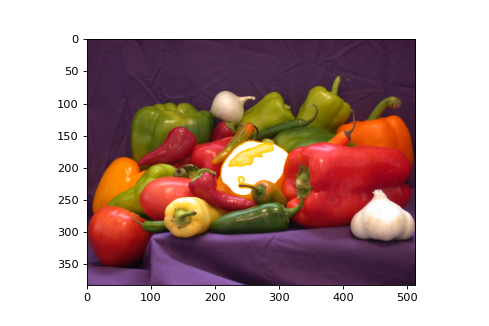

In [23]:
%matplotlib notebook
import imageio
import math
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
import scipy.ndimage as ndimage
from sys import setrecursionlimit

def load_img():
    img = imageio.imread('images/peppers.png')
    img_hsv = color.rgb2hsv(img)
    img_filtered = ndimage.median_filter(img_hsv, 5)
    
    return img, img_filtered, img_hsv

threshold = .08;

setrecursionlimit(100000)


def floodfill(img, mask, x, y, color, region):
    """Recursively grows region around seed point
    
    Args: 
        img (ndarray): The image in which the region is grown
        mask (boolean ndarray): Visited pixels.
        x (uint): X coordinate of the pixel. Checks if this pixels belongs to the region
        y (uint): Y coordinate of the pixel.
        color (list): The color at the seed position
        region (boolean ndarray): pixels which belong to the region
    """
    # YOUR CODE HERE
    neighbors = [[0,1],[0,-1],[1,0],[-1,0]]
    # visited this pixel
    mask[x,y]=True
    if np.linalg.norm(img[x,y] - color) < threshold:
        region[x,y] = True
        
        # call neighbors
        for n in neighbors:
            try: 
                if not mask[x+n[0],y+n[1]]:
                    floodfill(img, mask, x+n[0],y+n[1], color, region)
            except IndexError:
                        pass
        

        

def on_press(event):
    """Mouse button press event handler
    
    Args:
        event: The mouse event
    """
    print("pressed")
    y = math.floor(event.xdata)
    x = math.floor(event.ydata)
    

    
    # YOUR CODE HERE
    img, img_filtered, hsv = load_img()
    image = fill_from_pixel(img, img_filtered, x, y)

    
    plt.imshow(image)
    fig.canvas.draw()
    plt.show()
    

def fill_from_pixel(img, img_filtered, x,y):
    """ Calls floodfill from a pixel position
    
    Args:
        img (ndarray): IO image on which fill is drawn.
        img_filtered (ndarray): Processing image on which floodfill is computed.
        x (uint): Coordinates of pixel position.
        y (uint): Coordinates of pixel position.

    Returns:
        img (ndarray): Image with grown area in white
    """
    mask = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    region = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    color = img_filtered[x,y, :]
    floodfill(img_filtered, mask, x, y, color, region)
    img[region] = (255,255,255)
    
    return img


img, img_filtered, img_hsv = load_img()
img = fill_from_pixel(img, img_filtered, 200, 300) # Comment in to deactivate simple testing at fixed position
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img)

fig.canvas.mpl_connect('button_press_event', on_press)

plt.show()